In [34]:
import pandas as pd
import seaborn as sns
from scipy import stats

from utils import run_classifier, print_classifier_metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [66]:
data_types = {
    'customerID': pd.StringDtype(), 
    'gender': pd.StringDtype(), 
    'SeniorCitizen': pd.StringDtype(), 
    'Partner': pd.StringDtype(), 
    'Dependents': pd.StringDtype(),
    'tenure': pd.Int32Dtype(), 
    'PhoneService': pd.StringDtype(), 
    'MultipleLines': pd.StringDtype(), 
    'InternetService': pd.StringDtype(),
    'OnlineSecurity': pd.StringDtype(), 
    'OnlineBackup': pd.StringDtype(), 
    'DeviceProtection': pd.StringDtype(), 
    'TechSupport': pd.StringDtype(),
    'StreamingTV': pd.StringDtype(), 
    'StreamingMovies': pd.StringDtype(), 
    'Contract': pd.StringDtype(), 
    'PaperlessBilling': pd.StringDtype(),
    'PaymentMethod': pd.StringDtype(), 
    'MonthlyCharges': pd.Float64Dtype(), 
    'TotalCharges': pd.Float64Dtype(), 
    'Churn': pd.StringDtype()
}

# Total Charges has a few rows with a space only
df = pd.read_csv('data/churn.csv', dtype=data_types, na_values=[' ', ''])

In [67]:
df['customerID'].duplicated().sum()

np.int64(0)

In [68]:
# Sanity Check
# No duplicate records found - drop customerID
df.drop('customerID', axis=1, inplace=True)

In [69]:
df.count()

gender              7043
SeniorCitizen       7043
Partner             7043
Dependents          7043
tenure              7043
PhoneService        7043
MultipleLines       7043
InternetService     7043
OnlineSecurity      7043
OnlineBackup        7043
DeviceProtection    7043
TechSupport         7043
StreamingTV         7043
StreamingMovies     7043
Contract            7043
PaperlessBilling    7043
PaymentMethod       7043
MonthlyCharges      7043
TotalCharges        7032
Churn               7043
dtype: int64

**Total Charges includes 11 empty values**

In [70]:
# Fill missing Total Charges
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])

In [71]:

df['AverageCharges'] = df['TotalCharges'].div(df['tenure'].replace(0, 1))
df['RelativeDeviation'] = (df['AverageCharges'] - df['MonthlyCharges']) / df['MonthlyCharges']


In [72]:
categorical_columns = [ 'gender', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'PhoneService',
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'InternetService', 'Contract', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling' ]

boolean_columns = [ 'Churn']

for col in categorical_columns:
    df[col] = df[col].astype(pd.CategoricalDtype())

for col in boolean_columns:
    df[col] = ((df[col] == "Yes") | (df[col] == 1)).astype(pd.BooleanDtype())

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             7043 non-null   category
 1   SeniorCitizen      7043 non-null   category
 2   Partner            7043 non-null   category
 3   Dependents         7043 non-null   category
 4   tenure             7043 non-null   Int32   
 5   PhoneService       7043 non-null   category
 6   MultipleLines      7043 non-null   category
 7   InternetService    7043 non-null   category
 8   OnlineSecurity     7043 non-null   category
 9   OnlineBackup       7043 non-null   category
 10  DeviceProtection   7043 non-null   category
 11  TechSupport        7043 non-null   category
 12  StreamingTV        7043 non-null   category
 13  StreamingMovies    7043 non-null   category
 14  Contract           7043 non-null   category
 15  PaperlessBilling   7043 non-null   category
 16  Paymen

In [74]:
# Get churn rate
churn_rate = df['Churn'].mean() * 100
print(f"Churn rate: {churn_rate:.1f}%")

Churn rate: 26.5%


<Axes: >

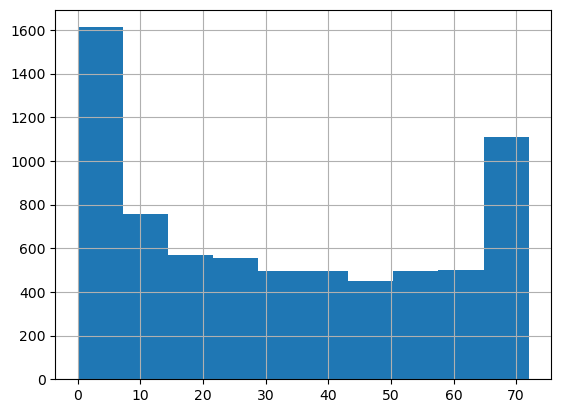

In [75]:
df['tenure'].hist()

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

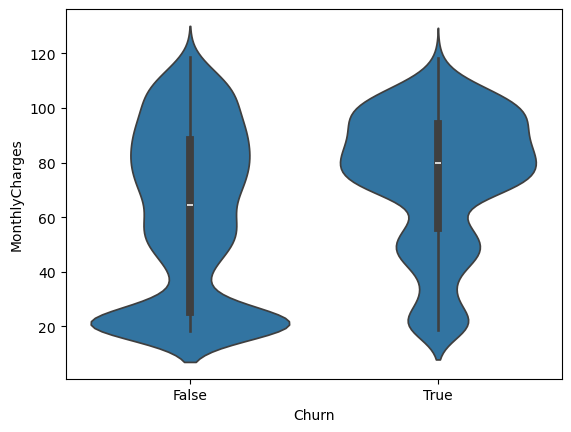

In [76]:
sns.violinplot(data=df, x='Churn', y='MonthlyCharges')

In [77]:
# T-test to see if means are significantly different
churned = df[df['Churn'] == True]['MonthlyCharges']
not_churned = df[df['Churn'] == False]['MonthlyCharges']

t_stat, p_value = stats.ttest_ind(churned, not_churned)
print(f"\nT-test for charge deviation:")
print(f"Churned mean: {churned.mean():.2f}")
print(f"Not churned mean: {not_churned.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value}")


T-test for charge deviation:
Churned mean: 74.44
Not churned mean: 61.27
T-statistic: 16.5367, p-value: 2.7066456068884154e-60


In [78]:
# T-test to see if means are significantly different
churned = df[df['Churn'] == True]['AverageCharges']
not_churned = df[df['Churn'] == False]['AverageCharges']

t_stat, p_value = stats.ttest_ind(churned, not_churned)
print(f"\nT-test for charge deviation:")
print(f"Churned mean: {churned.mean():.2f}")
print(f"Not churned mean: {not_churned.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value}")


T-test for charge deviation:
Churned mean: 74.43
Not churned mean: 61.18
T-statistic: 16.5318, p-value: 2.929468674304517e-60


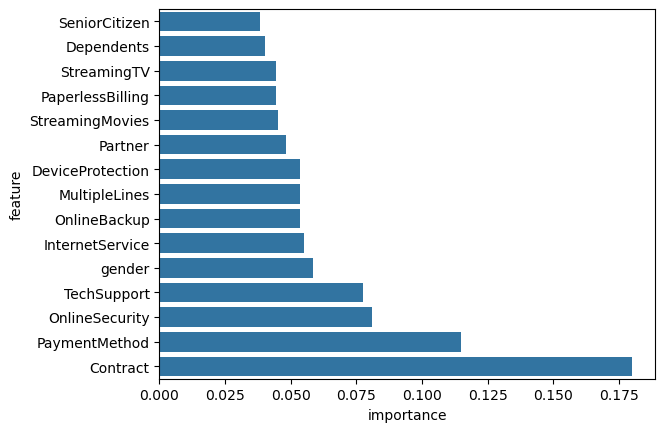


Top 10 Features by ML Importance:
             feature  importance
10           Partner    0.048316
5   DeviceProtection    0.053434
1      MultipleLines    0.053566
3       OnlineBackup    0.053618
13   InternetService    0.054917
0             gender    0.058644
6        TechSupport    0.077379
2     OnlineSecurity    0.081059
15     PaymentMethod    0.114721
14          Contract    0.179891


In [79]:
all_cat_features = [ 'gender', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'PhoneService',
                     'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                     'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling',
                     'InternetService', 'Contract', 'PaymentMethod' ]


from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

df_ml = df.copy()
label_encoders = {}

for col in all_cat_features:
    le = LabelEncoder()
    df_ml[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

X = df_ml[all_cat_features]
y = df_ml['Churn']

rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X, y)

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=True)

sns.barplot(data=feature_importance.tail(15), y='feature', x='importance')
plt.show()

print("\nTop 10 Features by ML Importance:")
print(feature_importance.tail(10))

In [86]:
X_important = feature_importance[feature_importance['importance'] >= 0.01]['feature']

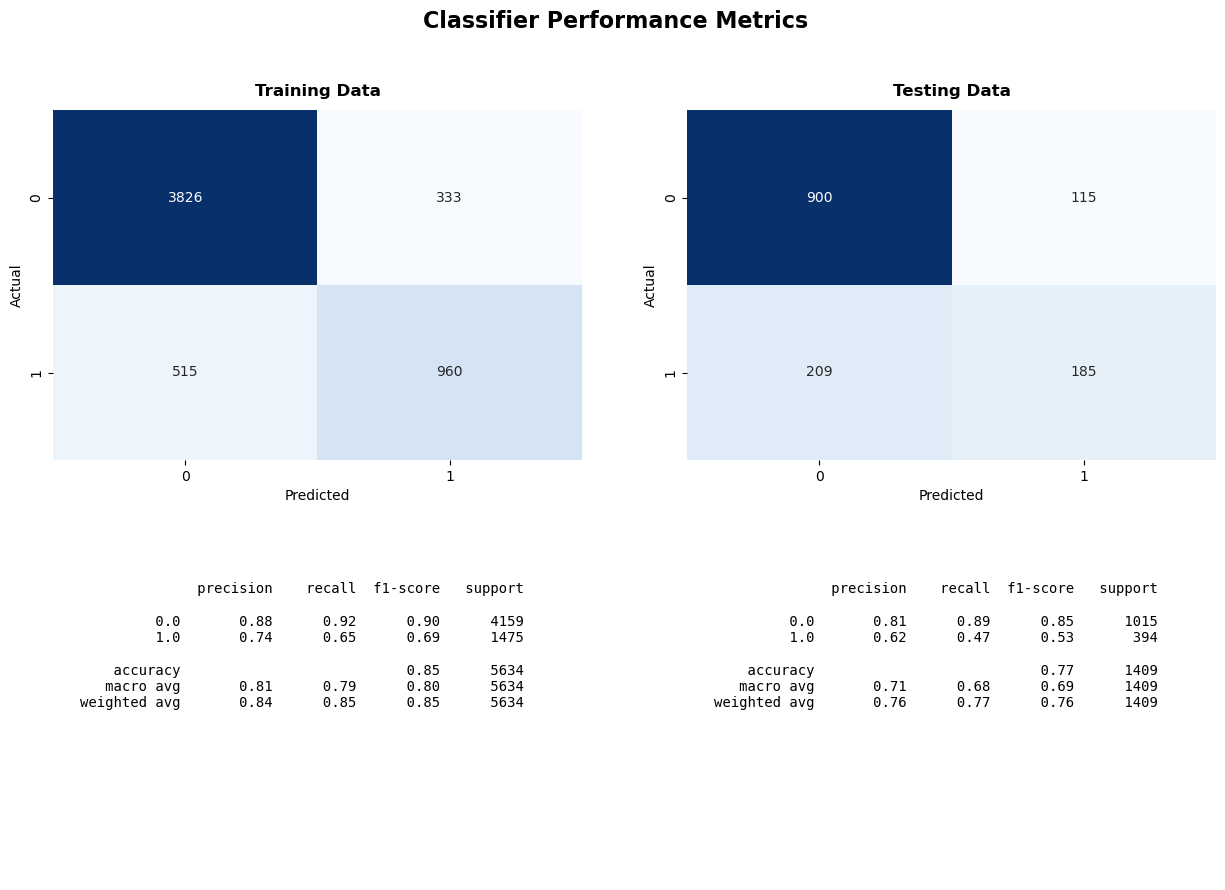

In [87]:
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=123)

print_classifier_metrics(model, df_ml[X_important], y, split_random_state=123)

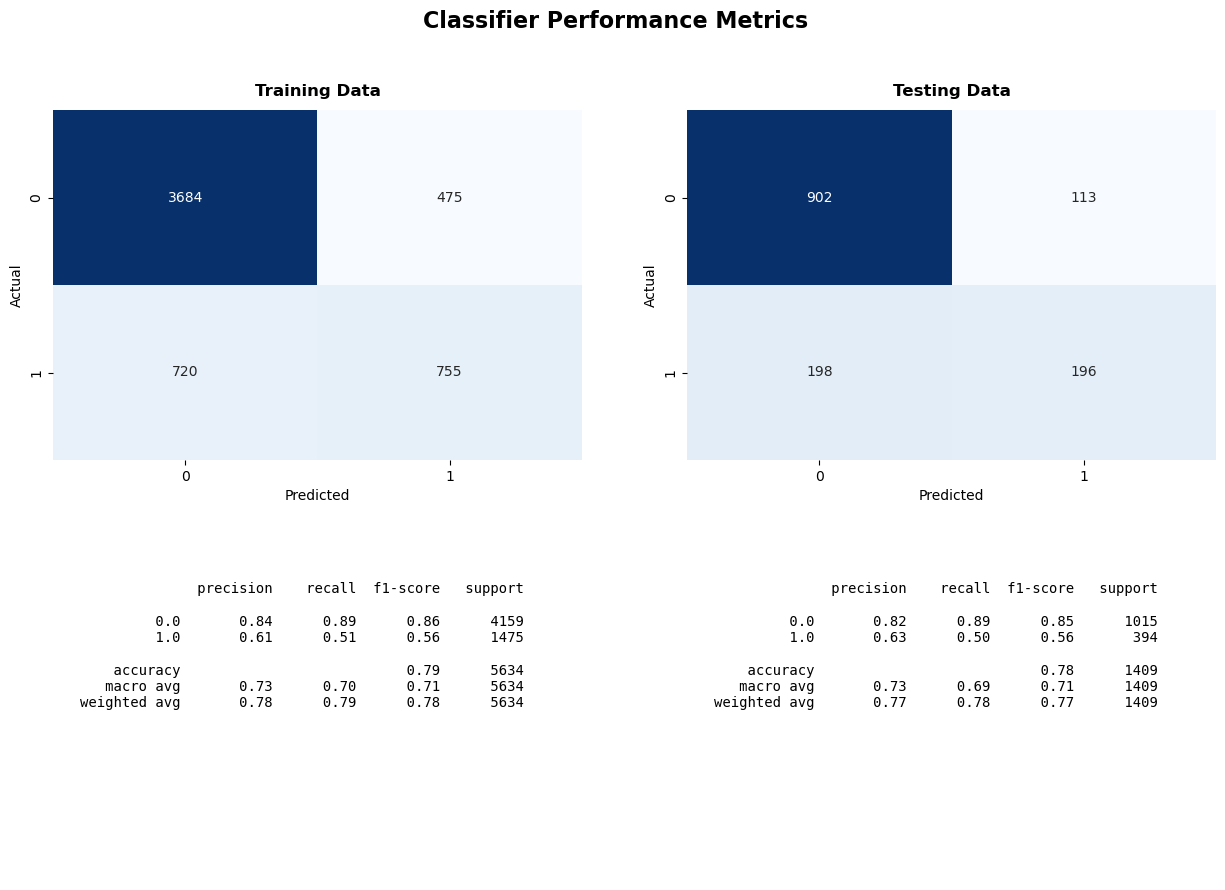

In [88]:
model = AdaBoostClassifier(n_estimators=200, random_state=123)

print_classifier_metrics(model, X, y, split_random_state=123)

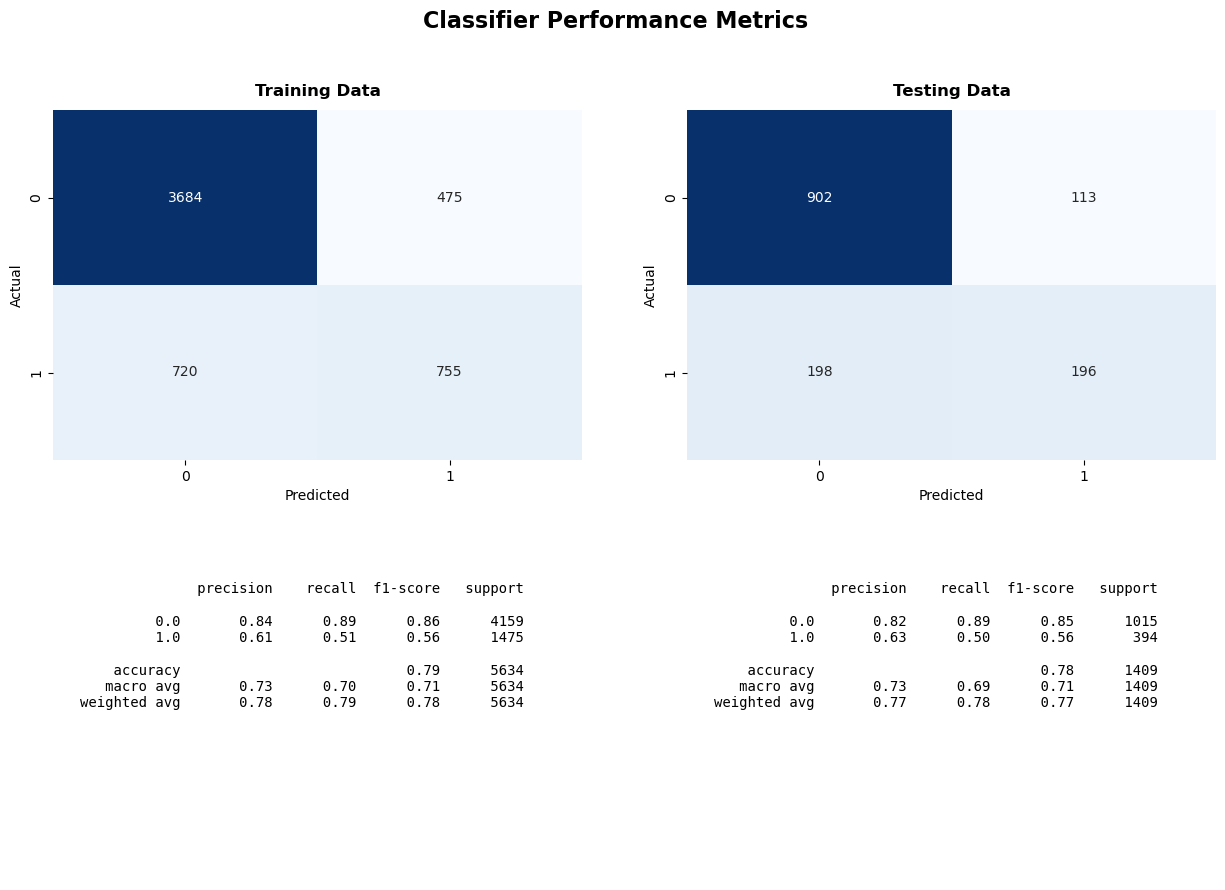

In [89]:
model = AdaBoostClassifier(n_estimators=200, random_state=123)

print_classifier_metrics(model, df_ml[X_important], y, split_random_state=123)

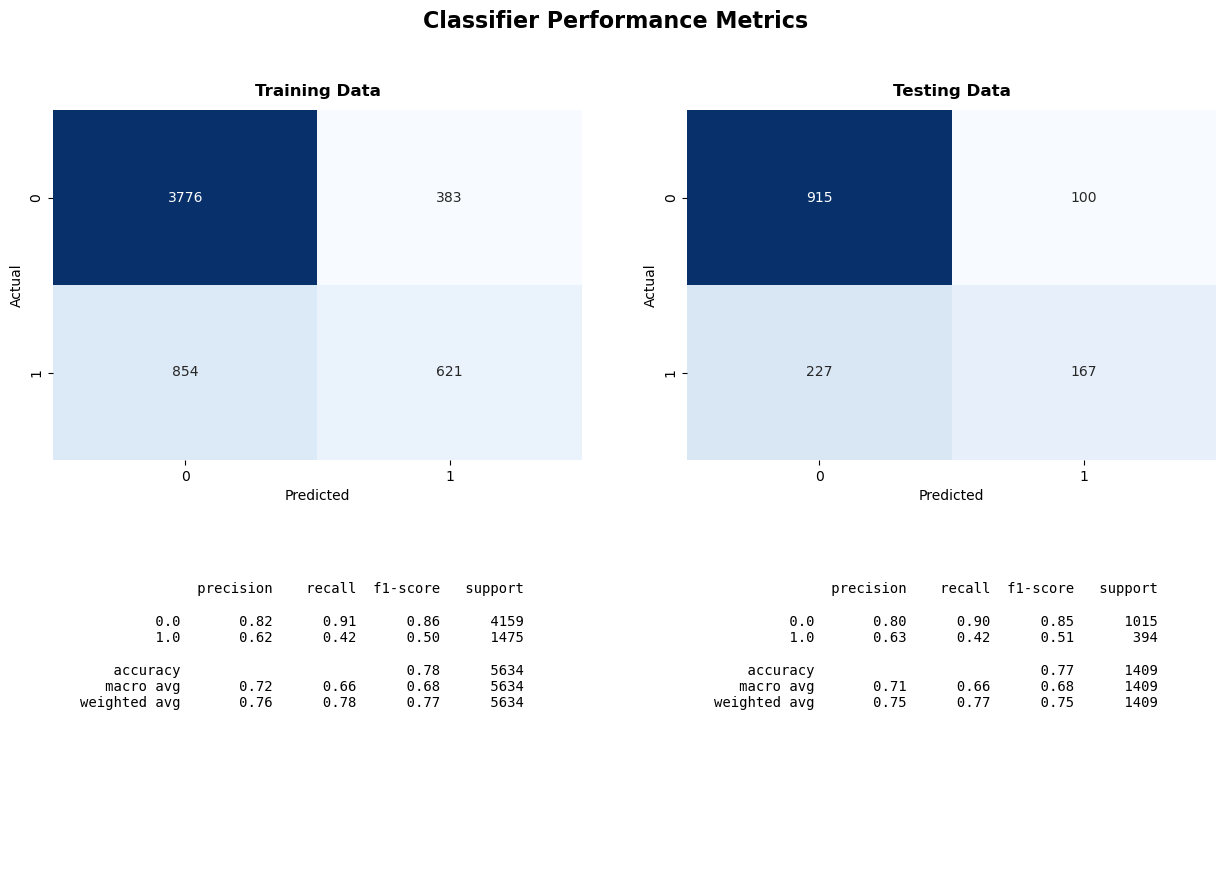

In [85]:
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4), n_estimators=200, random_state=123)

print_classifier_metrics(model, df_ml[X_important], y, split_random_state=123)

In [91]:
X_important = feature_importance[feature_importance['importance'] >= 0.1]['feature']

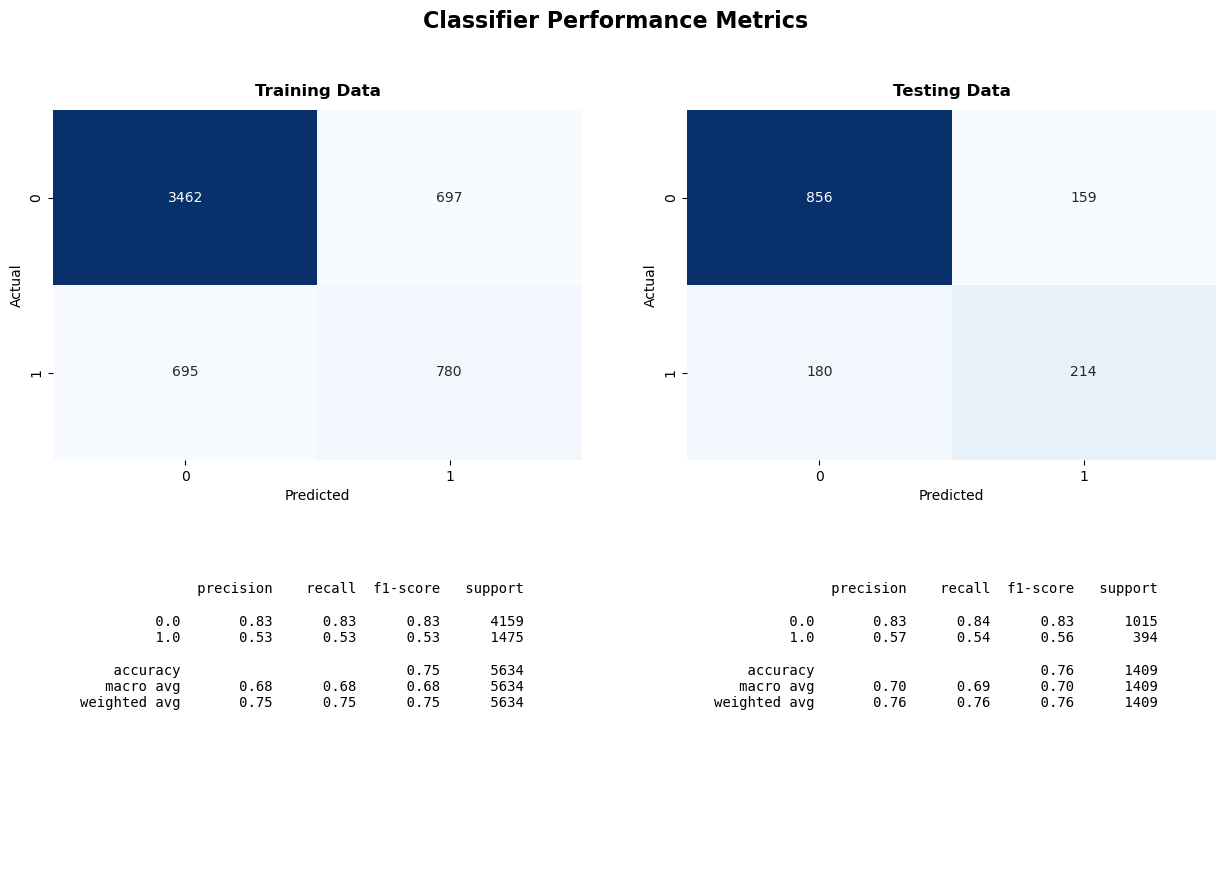

In [92]:
model = AdaBoostClassifier(n_estimators=200, random_state=123)

print_classifier_metrics(model, df_ml[X_important], y, split_random_state=123)